# Anatomy of a GPT

![Anatomy of a GPT](../assets/anatomy-of-a-gpt.jpg)

In this notebook, we're gonna have a look inside the models that we trained with `train.py` with different configurations. You can choose the models to try out by editing the list below:

In [1]:
RUNS = [
    "../runs/nlab-gpt-medium-8.7M-eb4543e4/nlab-gpt-medium-8.7M-eb4543e4-2025-12-16-49000-[best(2.0274)].pt",
    "../runs/nlab-gpt-small-4.3M-a32328c1/nlab-gpt-small-4.3M-a32328c1-2025-12-16-47500-[best(2.3026)].pt",
]

Next, we load `infer.py` so that we get access to `GenerativeRun`:

In [2]:
import sys

sys.path.append("..")
import infer

In [3]:
runs = list(map(infer.GenerativeRun.from_file, RUNS))
# We assume that all the runs were based on the same tokenizer

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for run in runs:
    run.model.to(device)

### Warmup

Let's check how each model generates text first:

In [5]:
for run in runs:
    print("\n" + "-" * 60 + f"\n{run.name}\n\nA functor is", end="", flush=True)
    for n, token in enumerate(run.generate("A functor is", device=device)):
        if n >= 64:
            break
        print(token, end="", flush=True)


------------------------------------------------------------
nlab-gpt-medium-8.7M-eb4543e4

A functor is a functor, but it is also natural to check that the only object is representable, while the core of $B$ is representable, but it is also a representable functor.

## Examples

* The terminal object functor $Y \colon A \to B$ is a functor. The functor category $X
------------------------------------------------------------
nlab-gpt-small-4.3M-a32328c1

A functor is _locally_ a functor in the sense of def. \ref{PresentationOfCosimplicialObjects}.

=--

+-- {: .num_remark}
###### Remark

For $X \in \mathcal{X}$ any object, write $C$ for the slice category of presheaves.

That's not too bad! Now we'll look at the _validation loss_ during training.

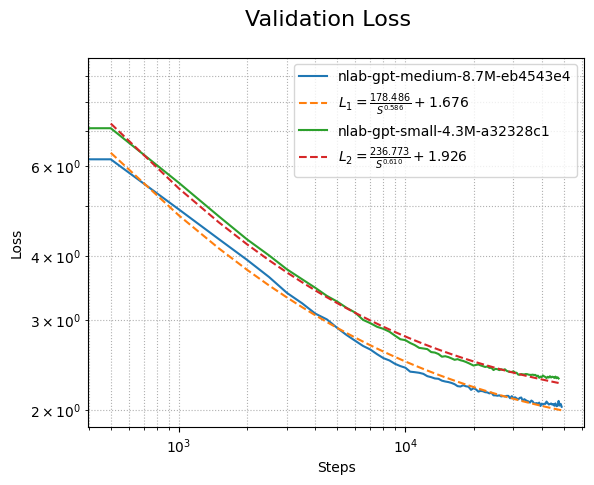

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

runs_with_data = []
for n, run in enumerate(runs):
    runs_with_data.append(
        (
            n,
            run,
            np.array([x["global_step"] for x in run.loss_history]),
            np.array([x["loss"]["val"] for x in run.loss_history]),
        )
    )


def power_law(x, a, b, c):
    return a * np.power(x, -b) + c


for n, run, xi, yi in runs_with_data:
    params, _ = scipy.optimize.curve_fit(
        # We silently avoid division by zero
        power_law,
        xdata=xi[1:],
        ydata=yi[1:],
        p0=[5.0, 0.3, 1.0],
    )
    a, b, c = params

    plt.loglog(xi, yi, label=run.name)
    plt.loglog(
        xi[1:],
        power_law(xi[1:], a, b, c),
        linestyle="--",
        label="$L_{%d} = \\frac{%.3f}{S^{%.3f}} + %.3f$" % (n + 1, a, b, c),
    )

plt.xlabel("Steps")
plt.ylabel("Loss")

plt.suptitle(f"Validation Loss", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig("../assets/validation-loss.png", dpi=300, bbox_inches="tight")
plt.show()

Notice how the larger model is consistently better than then smaller one! We can actually measure this gap with the _root mean squared error_:

In [7]:
def rmse(x1, y1, x2, y2):
    l = min(len(x1), len(x2))
    return np.sqrt(np.sum((y1[:l] - y2[:l]) ** 2.0) / l)


for n1, run1, x1, y1 in runs_with_data:
    for n2, run2, x2, y2 in runs_with_data:
        if n1 < n2:
            print(
                f"Root Mean Squared Error between {run1.name} and {run2.name}\n = {rmse(x1, y1, x2, y2)}"
            )

Root Mean Squared Error between nlab-gpt-medium-8.7M-eb4543e4 and nlab-gpt-small-4.3M-a32328c1
 = 0.30437409275177246


So, overall, the `medium` model was capable of compressing ~0.304 more bits of information than the `small` one.

### Visualizing Attention

We will now try to see what's happening under the hood. For each head in each layer, we'll look at the _attention weights_ to try to understand how each token of a fixed sentence attends to the other tokens.

Here's one possible sentence (but, of course, you can change it):

In [8]:
TEXT = "A presheaf is a contravariant functor into the category of small sets"

In [9]:
input_ids = runs[0].tokenizer.encode(TEXT).ids
labels = [runs[0].tokenizer.decode([token]) for token in input_ids]

print(
    f"The piece of text\n    {TEXT}\nis broken down into tokens the following way:\n    {labels}"
)

The piece of text
    A presheaf is a contravariant functor into the category of small sets
is broken down into tokens the following way:
    ['A', ' presheaf', ' is', ' a', ' contra', 'variant', ' functor', ' into', ' the', ' category', ' of', ' small', ' sets']


The code above helps us "see" what the Transformer actually sees (i.e. individual token, not words or characters). We now define a function that will properly render the attention weights:

In [10]:
def show_attention(run, input_ids, labels, device):
    fig, axes = plt.subplots(
        run.config.num_hidden_layers,
        run.config.num_attention_heads,
        figsize=(12, 2 * run.config.num_hidden_layers),
    )

    if run.config.num_hidden_layers == 1:
        axes = np.expand_dims(axes, 0)
    if run.config.num_attention_heads == 1:
        axes = np.expand_dims(axes, 1)

    def attention_callback(layer, head, attn_weights):
        # We assume there's only one batch
        attn_weights = attn_weights[0, :, :]
        T = attn_weights.shape[0]
        future_mask = np.triu(np.ones((T, T), dtype=bool), k=1)
        A_masked = np.ma.array(attn_weights, mask=future_mask)

        row_min = A_masked.min(axis=1, keepdims=True)
        row_max = A_masked.max(axis=1, keepdims=True)

        den_data = (row_max - row_min).filled(0.0)
        zero_variance_rows = (den_data < 1e-9).flatten()

        den_data[zero_variance_rows] = 1.0
        normalized = (A_masked - row_min) / den_data

        if np.any(zero_variance_rows):
            normalized[zero_variance_rows] = 1.0
        normalized.mask = future_mask

        ax = axes[layer, head]
        ax.imshow(
            normalized,
            aspect="auto",
            vmin=0.0,
            vmax=1.0,
            cmap="viridis",
            interpolation="nearest",
            origin="upper",
        )

        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))

        ax.set_xticklabels(labels, rotation=90, fontsize=8)
        ax.set_yticklabels(labels, fontsize=8)

        if head == 0:
            ax.set_ylabel(f"Layer {layer}", fontsize=10, fontweight="bold")
        if layer == 0:
            ax.set_title(f"Head {head}", fontsize=10)

        for spine in ax.spines.values():
            spine.set_visible(False)

    with torch.no_grad():
        run.model(
            torch.tensor([input_ids], device=device),
            attention_callback=attention_callback,
        )

    plt.suptitle(f"Per-Row Normalized Attention: {run.name}", fontsize=16, y=1.0)
    plt.tight_layout()
    plt.savefig(
        f"../assets/attention-scores-{run.name}.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

The function uses the special parameter `attention_callback` that I added to `model.Transformer` for this very purpose. Let's run the function now:

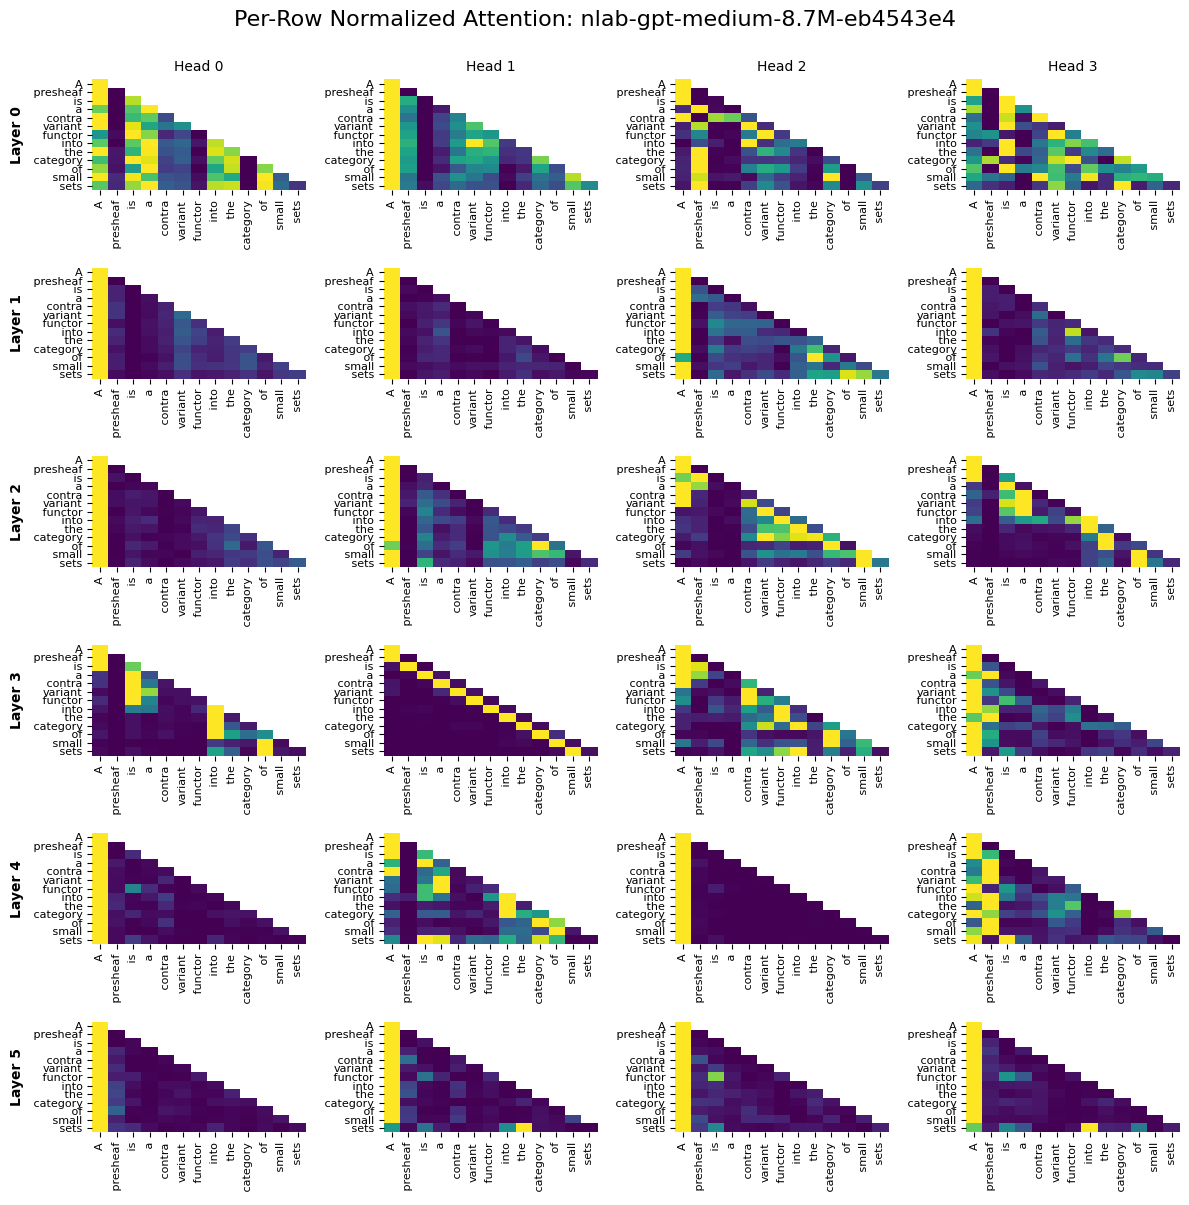

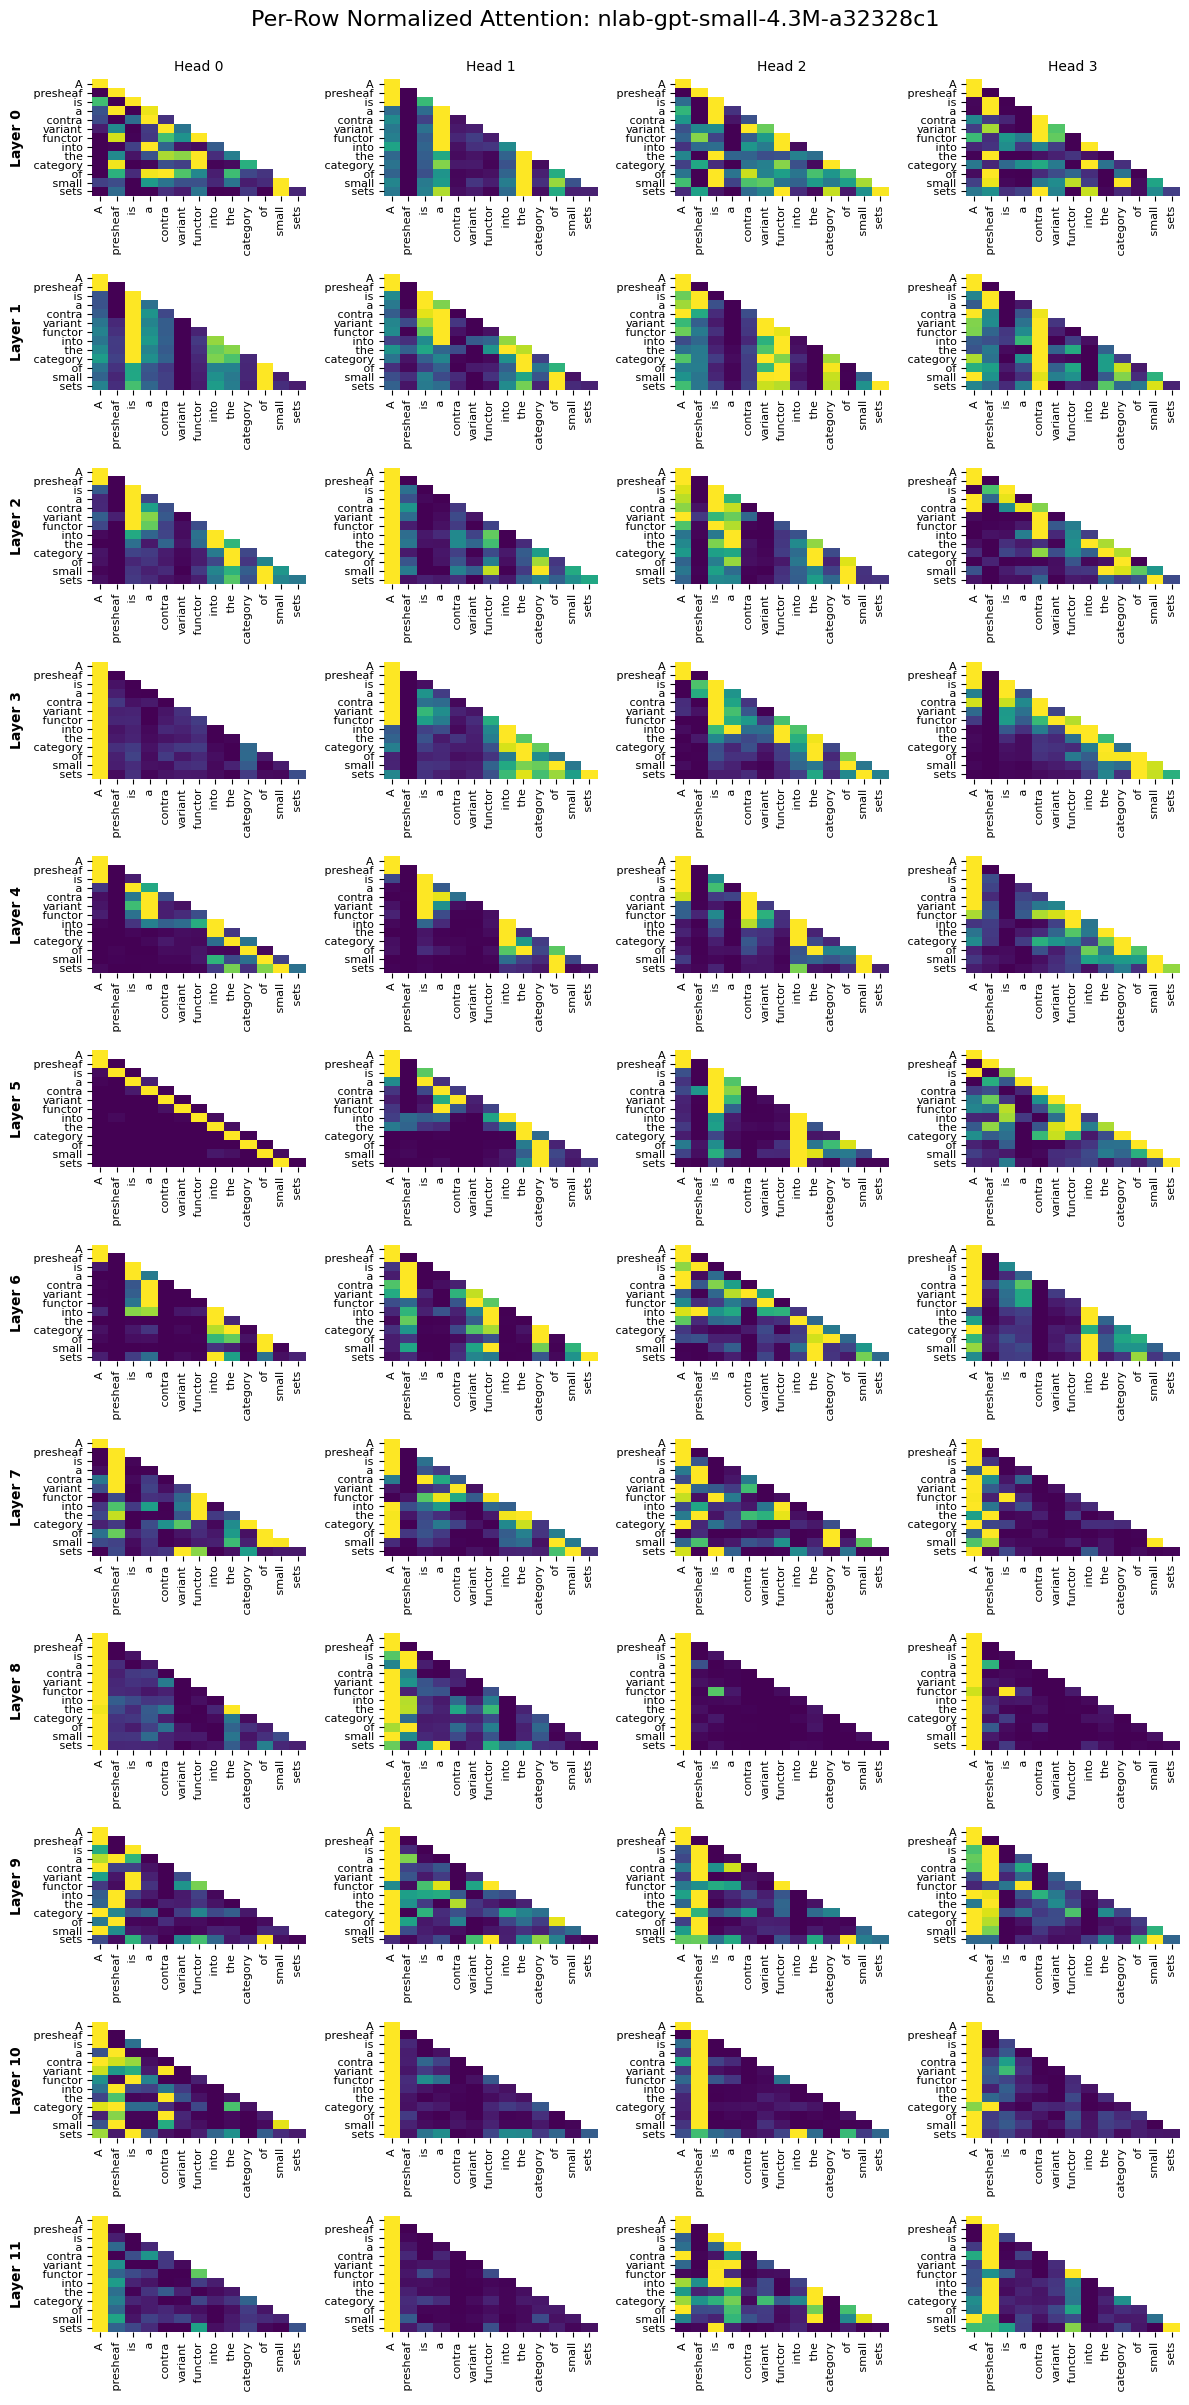

In [11]:
for run in runs:
    show_attention(run, input_ids, labels, device)

This is very interesting. We see that a lot of things seem to be happening inside of the very first layer.

Additionally, we see that more often than not, the first token gets "all the attention" (a vertical yellow bar in the first column). This is the so-called _attention sink_ that I have heard about and I want to learn about next.

### Head Redundancy

We will now look at how similar the heads are inside of a model. To that, we will sample random batches from the validation data set, compute the attention weights, then measure the difference across all heads using _cosine similarity_. This is a rather crude metric that will typically be between 0.5 and 1.0 because of the nature of attention weights.

Below is our cosine similarity function:

In [12]:
def row_wise_cosine_similarity_causal(A, B, eps=1e-8):
    batch_size, T, _ = A.shape

    mask = np.tril(np.ones((T, T), dtype=A.dtype))

    A = A * mask
    B = B * mask

    dot = np.sum(A * B, axis=-1)

    return np.mean(
        np.mean(
            dot / (np.linalg.norm(A, axis=-1) * np.linalg.norm(B, axis=-1) + eps),
            axis=-1,
        )
    )

We now sample the validation set on a few examples to get a good idea of the _head redundancy_:

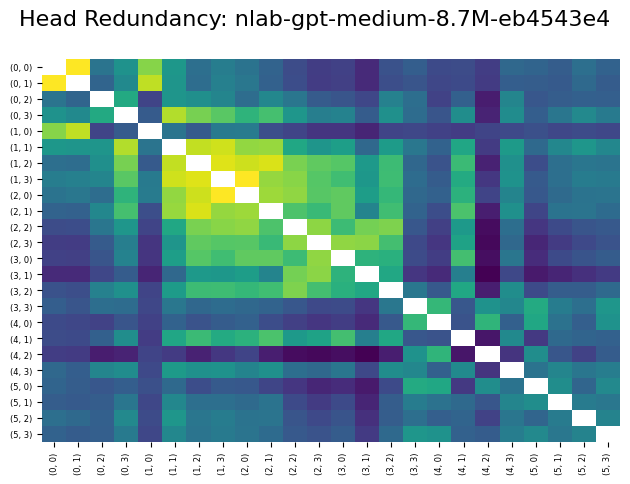

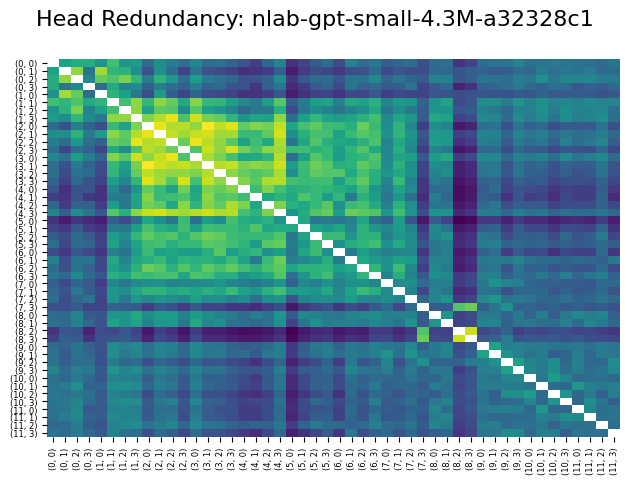

In [ ]:
import itertools

val_data = torch.load("../data/val_data.pt").to(device)

# How many times we should sample
MAX_STEPS = 10


# Coming straight form train.Trainer
def get_batch(run):
    N = val_data.size(0)
    start = torch.randint(
        0,
        N - run.config.max_position_embeddings - 1,
        (run.config.per_device_train_batch_size,),
        device=device,
    )
    pos = (
        start[:, None]
        + torch.arange(run.config.max_position_embeddings, device=device)[None, :]
    )
    return val_data[pos]


with torch.no_grad():
    for run in runs:
        # All the pairs (label, head) for the current run
        labels = list(
            itertools.chain.from_iterable(
                [
                    [(l, h) for h in range(run.config.num_attention_heads)]
                    for l in range(run.config.num_hidden_layers)
                ]
            )
        )
        score = np.identity(len(labels), dtype=np.float64)

        for _ in range(MAX_STEPS):
            weights = {}

            def attention_callback(layer, head, attn_weights):
                weights[layer, head] = attn_weights

            x = get_batch(run)
            # This will populate weights
            run.model(x, attention_callback=attention_callback)

            # We now compute the cosine similarity between every head
            for i, p in enumerate(labels):
                for j, q in enumerate(labels[:i]):
                    score[i][j] += row_wise_cosine_similarity_causal(
                        weights[p], weights[q]
                    )
                    score[j][i] = score[i][j]
        score = score / MAX_STEPS

        fig, ax = plt.subplots()
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))

        ax.set_xticklabels(labels, rotation=90, fontsize=6)
        ax.set_yticklabels(labels, fontsize=6)

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.imshow(
            np.ma.MaskedArray(
                score,
                mask=np.identity(len(labels), dtype=bool),
            ),
            cmap="viridis",
            aspect="auto",
            interpolation="nearest",
            origin="upper",
        )

        plt.suptitle(f"Head Redundancy: {run.name}", fontsize=16, y=1.0)
        plt.tight_layout()
        plt.savefig(
            f"../assets/head-redundancy-{run.name}.png", dpi=300, bbox_inches="tight"
        )
        plt.show()

**TODO** Investigate the Jensen-Shannon divergence to measure the so-called _semantic routing_.